# Predicting Eurovision Ranking (LinReg)

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import re
import sqlite3
import pandas as pd
from textblob import TextBlob
from collections import Counter
from random import randint
import csv
import numpy as np

## Aux functions

In [4]:
def get_tweet_sentiment(tweet):
    """
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    """

    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet['tweetText']))
    
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [5]:
def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

## Setup

In [29]:
hashtags = {}

# set country hashtags - semifinal 1
hashtags['2017_semi1'] = ['SWE', 'GEO', 'AUS', 'ALB', 'BEL', 'MNE', 'FIN', 'AZE', 'POR', 'GRE',\
                            'POL', 'MDA', 'ISL', 'CZE', 'CYP', 'ARM', 'SLO', 'LAT']

# set country hashtags - semifinal 2
hashtags['2017_semi2'] = ['AUT', 'BLR', 'DEN', 'EST', 'MKD', 'HUN', 'IRL', 'ISR', 'LTU', 'MLT', \
                            'NOR', 'ROM', 'SMR', 'SRB', 'SUI', 'NED', 'CRO', 'BUL']

# set country hashtags - final
hashtags['2017_final'] = ['ARM', 'AZE', 'ITA', 'MDA', 'POL', 'POR', 'UKR', 'AUS', 'BEL', 'CYP', 'FRA',\
                          'GER', 'GRE', 'ESP', 'GBR', 'SWE', 'BUL', 'BLR', 'CRO', 'HUN', 'DEN',\
                          'ISR', 'ROM', 'NOR', 'NED', 'AUT']

In [238]:
# read csv file with results
results_list = {'2017_semi1':[], '2017_semi2':[], '2017_final':[]}
with open('results.csv', 'r') as results_csv:
    csv_reader = csv.reader(results_csv, delimiter=',')
    for row in csv_reader:
        if len(row) > 0:
            if row[0] not in ('round'):
                results_list[row[0]].append({
                    'country':row[2],
                    'rank':row[3],
                    'televoting':row[4],
                    'jury':row[5]
                })

# create dataframe
results = pd.DataFrame()
for round in results_list:
    round_df = pd.DataFrame(results_list[round])
    round_df['round'] = round
    if len(results) == 0:
        results = round_df
    else:
        results = results.append(round_df, ignore_index=True)
    print('{}: {}'.format(round,len(results_list[round])))

# convert to numeric values
results['rank'] = pd.to_numeric(results['rank'], errors='coerce').fillna(0).astype(np.int64)
results['televoting'] = pd.to_numeric(results['televoting'], errors='coerce').fillna(0).astype(np.int64)
results['jury'] = pd.to_numeric(results['jury'], errors='coerce').fillna(0).astype(np.int64)

# add total points
results['total'] = results.apply(lambda r: int(r['jury']) + int(r['televoting']), axis=1)

# add % of total points
results['total_perc'] = results['total']/results['total'].sum()

# sort columns
results = results[['round', 'country', 'rank', 'jury', 'televoting', 'total', 'total_perc']]

2017_semi2: 18
2017_semi1: 18
2017_final: 26


## Compose the Data table (features and labels) from different rounds

In [244]:
all_rounds_data = pd.DataFrame()

for round_string in ['2017_final', '2017_semi1', '2017_semi2']:
    
    print('Processing round', round_string)

    #select db
    if round_string == '2017_final':
        sqlite_file = 'db_2017_friday_and_final.db'        
    else:
        sqlite_file = 'db_' + round_string + '.db'

    # Connect to the database sqlite file
    connection = sqlite3.connect(sqlite_file)
    db = connection.cursor()

    # read ALL tweets in english from db, evaluate sentiment, and count
    print('  Reading sentiments')
    round_sentiments = []
    for country in hashtags[round_string]:

        # get tweets from DB
        country_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw WHERE language='en' AND tweetText LIKE '%#{}%'".format(country), connection)

        # count number of sentiments
        sentiments_count = Counter(country_tweets.apply(get_tweet_sentiment, axis=1))

        # append country to list
        round_sentiments.append({'country': country, \
                               'positive': sentiments_count['positive'],\
                               'neutral': sentiments_count['neutral'],\
                               'negative': sentiments_count['negative']
                              })

    # read all tweets (to just count)
    print('  Counting tweets')
    round_tweet_counts = []
    for country in hashtags[round_string]:

        # get tweet count from DB
        db.execute("SELECT COUNT(*) AS count FROM TweetsRaw WHERE tweetText LIKE '%#{}%'".format(country))
        country_tweet_count = db.fetchone()[0]

        # append country to list
        round_tweet_counts.append({'country': country, \
                               'count': country_tweet_count
                              })

    # transform to pandas dataframe from sentiments list
    round_data = pd.DataFrame(round_sentiments)
    round_data['round'] = round_string

    # add total tweet count
    round_data['tweets'] = [tc['count'] for tc in round_tweet_counts]
        
    # merge with results
    round_data = pd.merge(round_data, results, on=['country','round'], how='left')
    
    # re-order columns
    round_data = round_data[['round','country',\
                                'tweets','negative','neutral','positive',\
                                'rank','jury','televoting','total', 'total_perc'
                              ]]    

    # append to dataframe with all rounds data
    if len(all_rounds_data) == 0: 
        print('  Initializing dataframe of length',len(round_data),'into global dataframe of length',len(all_rounds_data))
        all_rounds_data = round_data
        print('  Initialized global dataframe with length',len(all_rounds_data))
    else:
        print('  Appending dataframe of length',len(round_data),'into global dataframe of length',len(all_rounds_data))
        all_rounds_data = all_rounds_data.append(round_data, ignore_index=True)
        print('  Appended global dataframe with length',len(all_rounds_data))

Processing round 2017_final
  Reading sentiments
  Counting tweets
  Initializing dataframe of length 26 into global dataframe of length 0
  Initialized global dataframe with length 26
Processing round 2017_semi1
  Reading sentiments
  Counting tweets
  Appending dataframe of length 18 into global dataframe of length 26
  Appended global dataframe with length 44
Processing round 2017_semi2
  Reading sentiments
  Counting tweets
  Appending dataframe of length 18 into global dataframe of length 44
  Appended global dataframe with length 62


## Feature engineering

In [296]:
# create normalized features
"""
results['negative_norm'] = (results['negative'] - results['negative'].mean() ) / results['negative'].std()
results['neutral_norm'] = (results['neutral'] - results['neutral'].mean() ) / results['neutral'].std()
results['positive_norm'] = (results['positive'] - results['positive'].mean() ) / results['positive'].std()
results['tweets_norm'] = (results['tweets'] - results['tweets'].mean() ) / results['tweets'].std()
results['negative_norm'] = results['negative'] / results['negative'].sum()
results['neutral_norm'] = results['neutral'] / results['neutral'].sum()
results['positive_norm'] = results['positive'] / results['positive'].sum()
results['tweets_norm'] = results['tweets'] / results['tweets'].sum()
"""

# add percentages of features over the totals
all_rounds_data['positive_perc'] = all_rounds_data['positive'] / all_rounds_data['positive'].sum()
all_rounds_data['negative_perc'] = all_rounds_data['negative'] / all_rounds_data['negative'].sum()
all_rounds_data['neutral_perc'] = all_rounds_data['neutral'] / all_rounds_data['neutral'].sum()
all_rounds_data['tweets_perc'] = all_rounds_data['tweets'] / all_rounds_data['tweets'].sum()

# create log features
all_rounds_data['negative_log'] = np.log(1 + all_rounds_data['negative_perc'])
all_rounds_data['neutral_log'] = np.log(1 + all_rounds_data['neutral_perc'])
all_rounds_data['positive_log'] = np.log(1 + all_rounds_data['positive_perc'])
all_rounds_data['tweets_log'] = np.log(1 + all_rounds_data['tweets_perc'])

# create label 'isTopN'
all_rounds_data['isTop5'] = all_rounds_data.apply(lambda r: 1 if r['rank']<=5 else 0, axis=1)
all_rounds_data['isTop10'] = all_rounds_data.apply(lambda r: 1 if r['rank']<=10 else 0, axis=1)

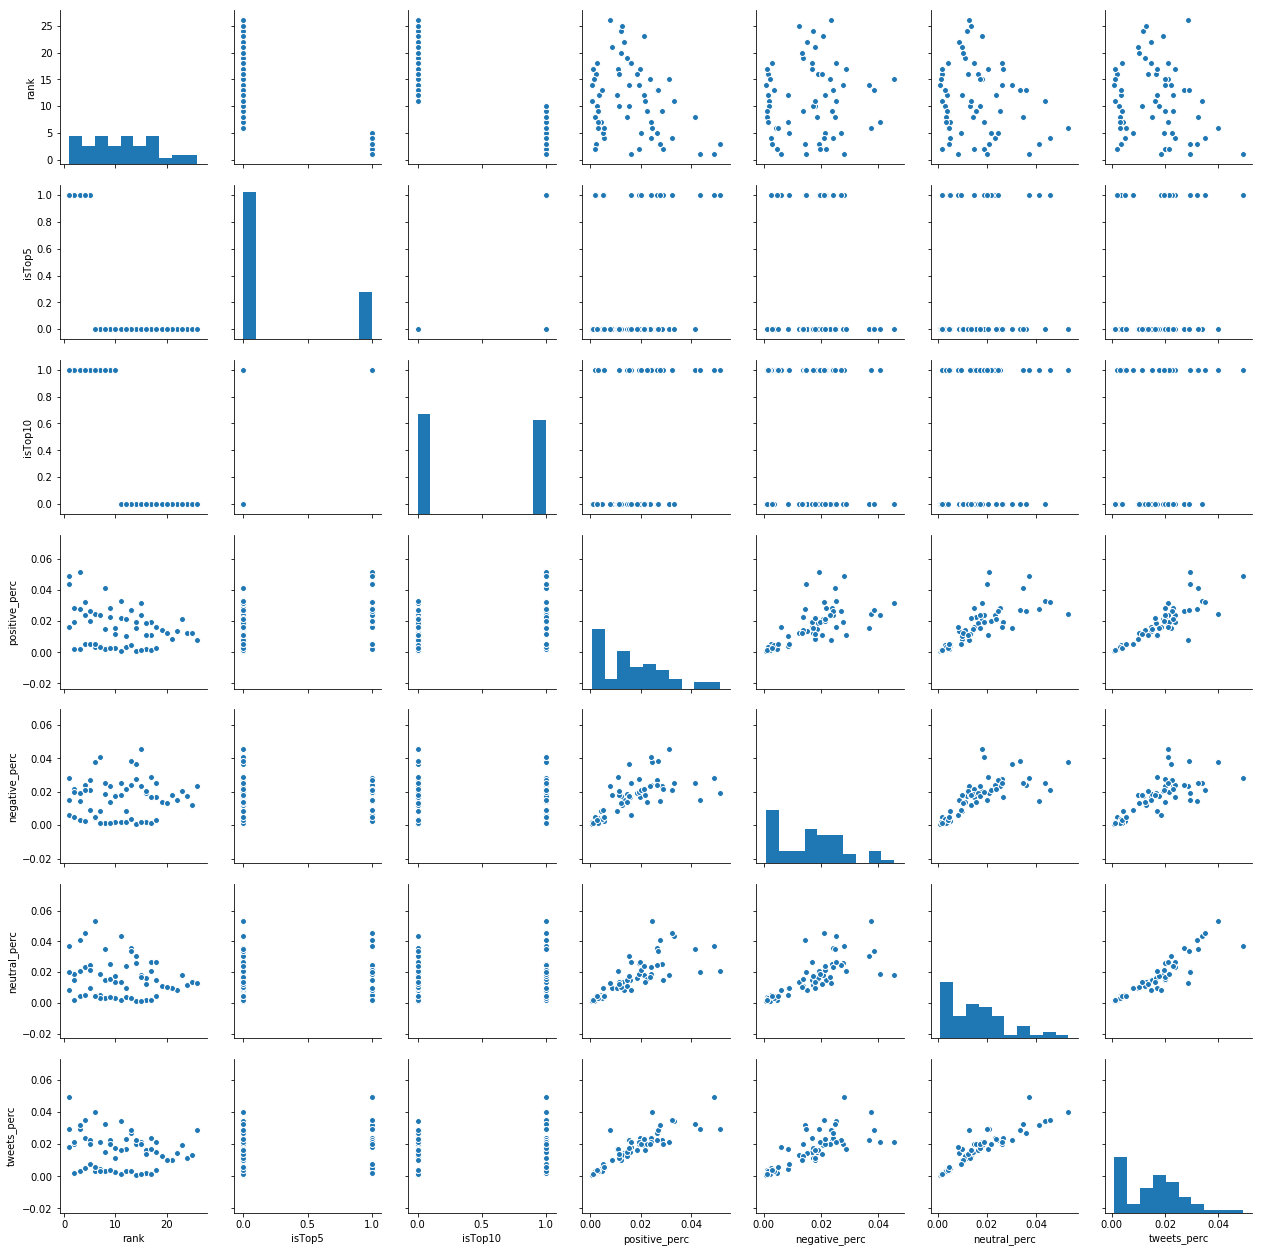

In [311]:
# Eplore features
import matplotlib as mpl
import seaborn as sns
columns = [#'tweets', 'negative', 'neutral', 'positive',\
           'rank', 'isTop5', 'isTop10',\
           #'jury', 'televoting', 'total', 'total_perc',\
           'positive_perc', 'negative_perc', 'neutral_perc', 'tweets_perc']
           #'negative_log', 'neutral_log','positive_log', 'tweets_log']
data_to_plot = all_rounds_data[columns]
sns.pairplot(data_to_plot)

## Linear Regression Prediction model

In [290]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [287]:
# set the features to analyze in the model
features = ['negative', 'neutral', 'positive', 'tweets']
#features = ['negative_log', 'neutral_log', 'positive_log', 'tweets_log']
#features = ['negative_perc', 'neutral_perc', 'positive_perc', 'tweets_perc']
features_string = ' + '.join(features)

# create input matrix and outut array
y, X = dmatrices('rank ~ {}'.format(features_string), all_rounds_data, return_type = 'dataframe')

# sklearn split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,1000))
print('X_train: {}\nX_test:  {}\ny_train: {}\ny_test:  {}\n'.format(len(X_train),len(X_test),len(y_train),len(y_test)))

# Linear Regression model with sklearn
model = LinearRegression(fit_intercept = True, normalize = False, copy_X=True)
regressor = model.fit(X_train, y_train.values.ravel())

# print results
print("Score train: {}".format(regressor.score(X_train, y_train)))
print("Score test:  {}\n".format(regressor.score(X_test, y_test)))

# print feature relationship
features_tmp = np.insert(features,0,'intercept')
print(pd.DataFrame(list(zip(features_tmp, model.coef_.ravel())), columns=['features','coefs']))

# predict test
pd.DataFrame(list(zip(model.predict(X_test), y_test.values.ravel())), columns=['predicted','real']).sort_values('predicted', ascending=False)

X_train: 43
X_test:  19
y_train: 43
y_test:  19

Score: 0.11281157537924924

   features     coefs
0  intercep  0.000000
1  negative  0.062673
2   neutral -0.008488
3  positive -0.023787
4    tweets  0.003283


,predicted,real
2,16.355526,14.0
6,12.908487,18.0
17,12.733425,7.0
12,12.645109,24.0
0,12.276568,8.0
7,12.084381,12.0
11,11.948920,11.0
5,11.546736,3.0
16,11.484938,17.0
1,11.439585,16.0


## Logistic Regression with isTopN as label

In [388]:
isTopN = 'isTop10'

# set the features to analyze in the model
#features = ['negative', 'neutral', 'positive', 'tweets']
#features = ['negative_log', 'neutral_log', 'positive_log', 'tweets_log']
features = ['negative_perc', 'neutral_perc', 'positive_perc', 'tweets_perc']
features_string = ' + '.join(features)

# create input matrix and outut array
y, X = dmatrices('{} ~ {}'.format(isTopN, features_string), all_rounds_data, return_type = 'dataframe')

# sklearn split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,1000))
print('X_train: {}\nX_test:  {}\ny_train: {}\ny_test:  {}\n'.format(len(X_train),len(X_test),len(y_train),len(y_test)))

# Linear Regression model with sklearn
regularization = 0.001
model = LogisticRegression(fit_intercept = False, C = 1/regularization)
regressor = model.fit(X_train, y_train.values.ravel())

# print results
print("Score train: {}".format(regressor.score(X_train, y_train)))
print("Score test:  {}\n".format(regressor.score(X_test, y_test)))

# print feature relationship
features_tmp = np.insert(features,0,'intercept')
print(pd.DataFrame(list(zip(features_tmp, model.coef_.ravel())), columns=['features','coefs']))

# predict test
#pd.DataFrame(list(zip(model.predict(X_test), y_test.values.ravel())), columns=['predicted','real']).sort_values('predicted', ascending=False)

# compute the new predicted score using the feature weights modeled in Logistic Regression
all_rounds_data['predicted_score'] = np.dot(X.values, model.coef_.T)

# Ranking
print("\nAccuracy Top 5: {}%".format(5*all_rounds_data.sort_values(by = 'predicted_score', ascending = False)[0:20]['isTop5'].sum()))
print("Accuracy Top 10: {}%".format(5*all_rounds_data.sort_values(by = 'predicted_score', ascending = False)[0:20]['isTop10'].sum()))
all_rounds_data.sort_values(by = ['round','predicted_score'], ascending = False)

X_train: 49
X_test:  13
y_train: 49
y_test:  13

Score train: 0.6530612244897959
Score test:  0.5384615384615384

        features      coefs
0      intercept  -0.159001
1  negative_perc -32.140795
2   neutral_perc  13.527127
3  positive_perc  18.318528
4    tweets_perc   8.591766

Accuracy Top 5: 50%
Accuracy Top 10: 70%


,round,country,tweets,negative,neutral,positive,rank,jury,televoting,total,...,negative_perc,neutral_perc,tweets_perc,negative_log,neutral_log,positive_log,tweets_log,isTop5,isTop10,predicted_score
51,2017_semi2,ISR,2201,70,866,469,3,75,132,207,...,0.014315,0.041006,0.032034,0.014213,0.040187,0.027161,0.031531,1,1,0.715189
61,2017_semi2,BUL,2014,73,427,741,1,199,204,403,...,0.014928,0.020219,0.029312,0.014818,0.020017,0.042582,0.028891,1,1,0.683410
59,2017_semi2,NED,2405,103,965,552,4,149,51,200,...,0.021063,0.045693,0.035003,0.020845,0.044680,0.031892,0.034404,1,1,0.676467
60,2017_semi2,CRO,2225,122,733,705,8,37,104,141,...,0.024949,0.034708,0.032383,0.024643,0.034119,0.040554,0.031870,0,1,0.545014
45,2017_semi2,BLR,1367,67,333,383,9,55,55,110,...,0.013701,0.015768,0.019896,0.013608,0.015645,0.022235,0.019700,0,1,0.196737
58,2017_semi2,SUI,1579,105,500,363,12,48,49,97,...,0.021472,0.023675,0.022981,0.021245,0.023399,0.021086,0.022721,0,0,0.058940
49,2017_semi2,HUN,1479,97,399,328,2,66,165,231,...,0.019836,0.018893,0.021526,0.019642,0.018717,0.019073,0.021297,1,1,-0.003314
57,2017_semi2,SRB,1129,87,285,372,11,53,45,98,...,0.017791,0.013495,0.016432,0.017635,0.013405,0.021604,0.016298,0,0,-0.007054
54,2017_semi2,NOR,1360,104,457,341,5,137,52,189,...,0.021268,0.021639,0.019794,0.021045,0.021408,0.019821,0.019600,1,1,-0.013074
46,2017_semi2,DEN,1221,84,363,262,10,96,5,101,...,0.017178,0.017188,0.017771,0.017032,0.017042,0.015264,0.017615,0,1,-0.044166
